In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology, measure
import os
import cv2
from scipy.ndimage import gaussian_filter, uniform_filter
from tqdm import tqdm
import time

In [ ]:
# sample_images= []
# sample_masks = []
# test_images= []
# test_masks = []
# for i in range(1,16):
#     sample_img = nib.load('C:\\Users\\prita\\Desktop\\AIMIA\AIMIA_Assignment_1\\Q2\\Sample\\SampleImages\\dwi_slice_'+str(i)+'.nii.gz')
#     sample_mask = nib.load('C:\\Users\\prita\\Desktop\\AIMIA\AIMIA_Assignment_1\\Q2\\Sample\\SampleMasks\\dwi_mask_'+str(i)+'.nii.gz')
#     test_img = nib.load('C:\\Users\\prita\\Desktop\\AIMIA\AIMIA_Assignment_1\\Q2\\Test\\TestImages\\dwi_slice_'+str(i)+'.nii.gz')
#     test_mask = nib.load('C:\\Users\\prita\\Desktop\\AIMIA\AIMIA_Assignment_1\\Q2\\Test\\TestMasks\\dwi_mask_'+str(i)+'.nii.gz')
#     sample_images.append(sample_img.get_fdata()[0,:,:])
#     sample_masks.append(sample_mask.get_fdata()[0,:,:])
#     test_images.append(test_img.get_fdata()[0,:,:])
#     test_masks.append(test_mask.get_fdata()[0,:,:])


In [2]:
sample_images= []
sample_masks = []
test_images= []
test_masks = []
for i in range(1,16):
    sample_img = nib.load('Q2/Sample/SampleImages/dwi_slice_'+str(i)+'.nii.gz')
    sample_mask = nib.load('Q2/Sample/SampleMasks/dwi_mask_'+str(i)+'.nii.gz')
    test_img = nib.load('Q2/Test/TestImages/dwi_slice_'+str(i)+'.nii.gz')
    test_mask = nib.load('Q2/Test/TestMasks/dwi_mask_'+str(i)+'.nii.gz')
    sample_images.append(sample_img.get_fdata()[0,:,:])
    sample_masks.append(sample_mask.get_fdata()[0,:,:])
    test_images.append(test_img.get_fdata()[0,:,:])
    test_masks.append(test_mask.get_fdata()[0,:,:])

In [19]:
def clahe(img, clip_limit=40.0, tile_grid_size=(8, 8), nbins=256):
    """
    Apply CLAHE to a grayscale image using NumPy (no OpenCV).
    
    Args:
        img (2D np.ndarray): Grayscale input image (uint8).
        clip_limit (float): Maximum allowed histogram bin count (contrast limiting).
        tile_grid_size (tuple): Number of tiles along (rows, cols).
        nbins (int): Number of histogram bins (default 256 for 8-bit).
        
    Returns:
        enhanced (2D np.ndarray): CLAHE-enhanced image.
    """
    # Ensure grayscale uint8
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255).astype(np.uint8)

    H, W = img.shape
    n_tiles_y, n_tiles_x = tile_grid_size
    tile_h, tile_w = int(np.ceil(H / n_tiles_y)), int(np.ceil(W / n_tiles_x))

    # Store mappings for each tile
    mappings = np.zeros((n_tiles_y, n_tiles_x, nbins), dtype=np.uint8)

    # Process each tile
    for ty in range(n_tiles_y):
        for tx in range(n_tiles_x):
            y0, y1 = ty * tile_h, min((ty+1) * tile_h, H)
            x0, x1 = tx * tile_w, min((tx+1) * tile_w, W)
            tile = img[y0:y1, x0:x1]

            # Histogram
            hist, _ = np.histogram(tile, bins=nbins, range=(0, 256))

            # Clip histogram
            excess = np.sum(np.maximum(hist - clip_limit, 0))
            hist = np.minimum(hist, clip_limit)
            hist += excess // nbins  # redistribute uniformly
            for i in range(excess.astype(np.uint16) % nbins):
                hist[i] += 1

            # CDF mapping
            cdf = np.cumsum(hist)
            cdf = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
            cdf = cdf.astype(np.uint8)

            mappings[ty, tx] = cdf

    # Apply mapping with bilinear interpolation between tiles
    enhanced = np.zeros_like(img, dtype=np.uint8)
    for i in range(H):
        for j in range(W):
            # Find surrounding tiles
            ty, tx = i / tile_h - 0.5, j / tile_w - 0.5
            ty0, tx0 = int(np.floor(ty)), int(np.floor(tx))
            ty1, tx1 = ty0 + 1, tx0 + 1

            # Clip indices
            ty0, ty1 = np.clip([ty0, ty1], 0, n_tiles_y - 1)
            tx0, tx1 = np.clip([tx0, tx1], 0, n_tiles_x - 1)

            # Weights for interpolation
            wy, wx = ty - ty0, tx - tx0

            val = img[i, j]
            # Interpolate between four tiles
            mapped_val = (
                (1-wy)*(1-wx)*mappings[ty0, tx0, val] +
                (1-wy)*wx*mappings[ty0, tx1, val] +
                wy*(1-wx)*mappings[ty1, tx0, val] +
                wy*wx*mappings[ty1, tx1, val]
            )
            enhanced[i, j] = int(mapped_val)

    return enhanced


In [6]:
img =sample_images[5]
enhanced_img = clahe(img, clip_limit=80.0, tile_grid_size=(10,10), nbins=256)

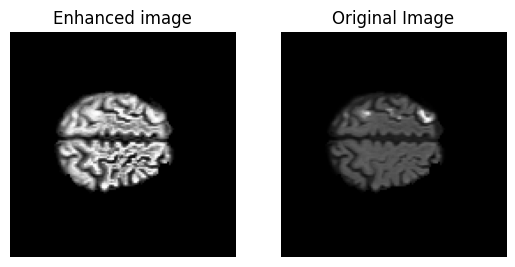

In [7]:
plt.subplot(1,2,1)
plt.imshow(enhanced_img,cmap='gray')
plt.title("Enhanced image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(sample_images[5], cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

In [26]:
enhanced_images = []
for img in sample_images:
    enhanced_img = clahe(img, clip_limit=20.0, tile_grid_size=(10,10), nbins=256)
    enhanced_images.append(enhanced_img)

/var/folders/qf/7spkdf0j6rz5bsyt67wb978w0000gp/T/ipykernel_1047/4219382669.py:44: RuntimeWarning: invalid value encountered in divide
  cdf = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
/var/folders/qf/7spkdf0j6rz5bsyt67wb978w0000gp/T/ipykernel_1047/4219382669.py:45: RuntimeWarning: invalid value encountered in cast
  cdf = cdf.astype(np.uint8)


In [3]:
def normalize_intensity(img, method='minmax'):
    """Normalize intensities to zero-mean unit-variance or min-max"""
    x = img.copy().astype(np.float32)
    if method == 'zscore':
        m = np.mean(x)
        s = np.std(x)
        if s == 0:
            return x - m
        return (x - m) / s
    elif method == 'minmax':
        mn = x.min()
        mx = x.max()
        if mx == mn:
            return x - mn
        return (x - mn) / (mx - mn)
    else:
        raise ValueError("Unknown method")

In [4]:
def gaussian_smooth(img, sigma=0.5):
    """Apply Gaussian smoothing"""
    return gaussian_filter(img, sigma=sigma)

In [ ]:
plt.figure(figsize=(12, 12))
sigmas = [0.1, 0.5, 1, 2]
for i,sigma in enumerate(sigmas):
    smoothed_images = gaussian_smooth(sample_images[5], sigma=sigma)
    title = f"Gaussian Smoothing with sigma={sigma}"
    plt.subplot(2, 2, i + 1)
    plt.imshow(smoothed_images)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
plt.show()

In [9]:
def average_filter(img, size=3):
    """Apply average filtering"""
    return uniform_filter(img, size=size)

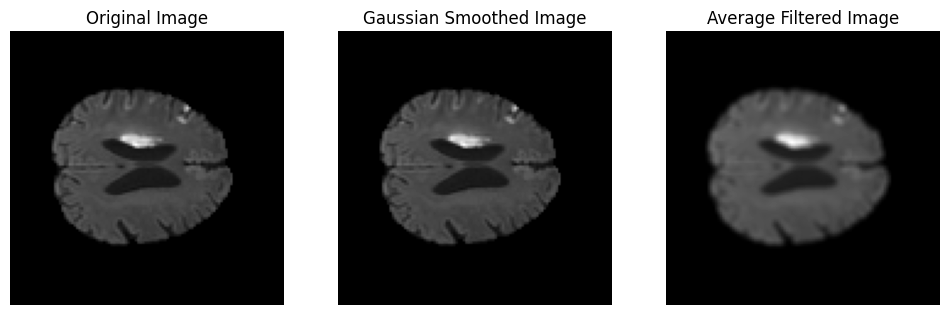

In [10]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(sample_images[0], cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(gaussian_smooth(sample_images[0], sigma=0.1), cmap='gray')
plt.title("Gaussian Smoothed Image")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(average_filter(sample_images[0], size=3), cmap='gray')
plt.title("Average Filtered Image")
plt.axis('off')
plt.show()

In [17]:
def plot_histogram(image, title):
    image = normalize_intensity(image, method='minmax')
    plt.hist(image.ravel(), bins=50, color='blue', alpha=0.7, density=True)
    plt.title(title)
    plt.xlabel('Intensity Value')
    plt.ylabel('Frequency')
    plt.grid()
    # plt.show()
    

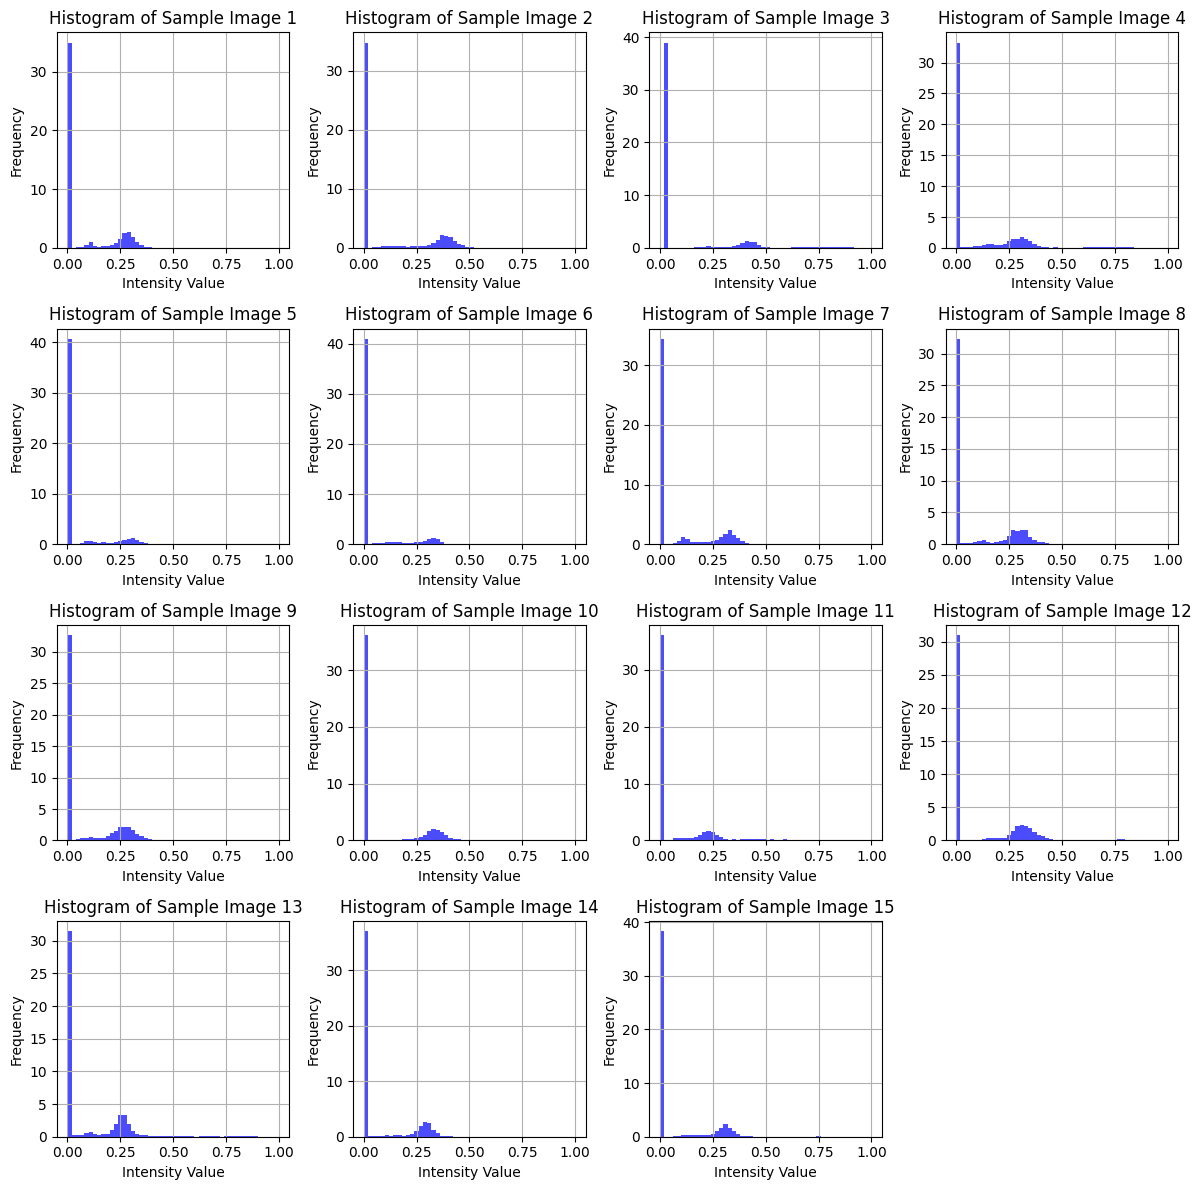

In [18]:
title = "Histogram of Sample Image"
plt.figure(figsize=(12, 12))
for idx in range(15):
    plt.subplot(4, 4, idx + 1)
    plot_histogram(sample_images[idx], f"{title} {idx+1}")
plt.tight_layout()
plt.show()

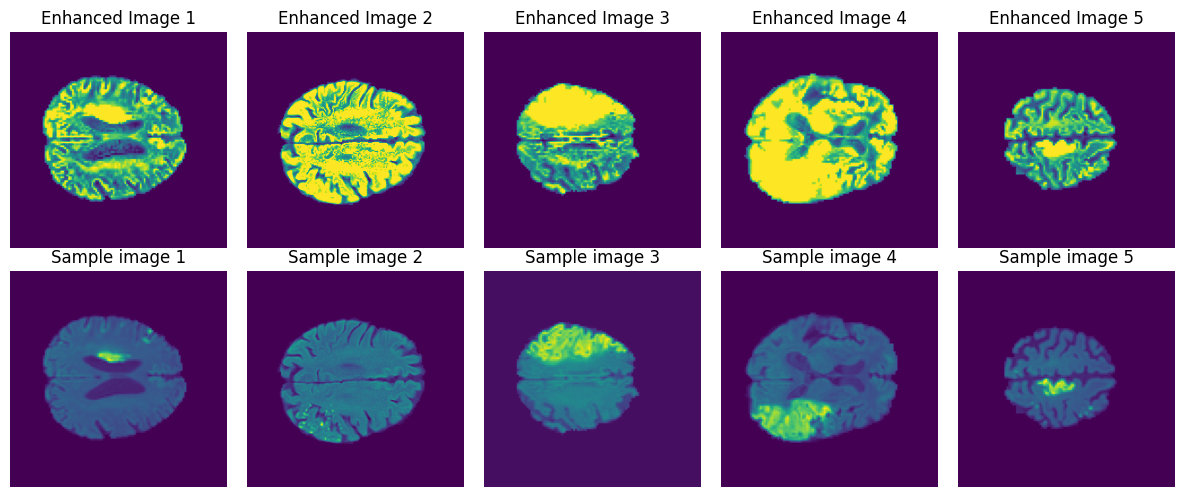

In [112]:
plt.figure(figsize=(12,5))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(enhanced_images[i])
    plt.title('Enhanced Image '+str(i+1))
    plt.axis('off')
for i in range(5):
    plt.subplot(2,5,i+6)
    plt.imshow(sample_images[i])
    plt.title('Sample image '+str(i+1))
    plt.axis('off')
plt.tight_layout()
plt.show()

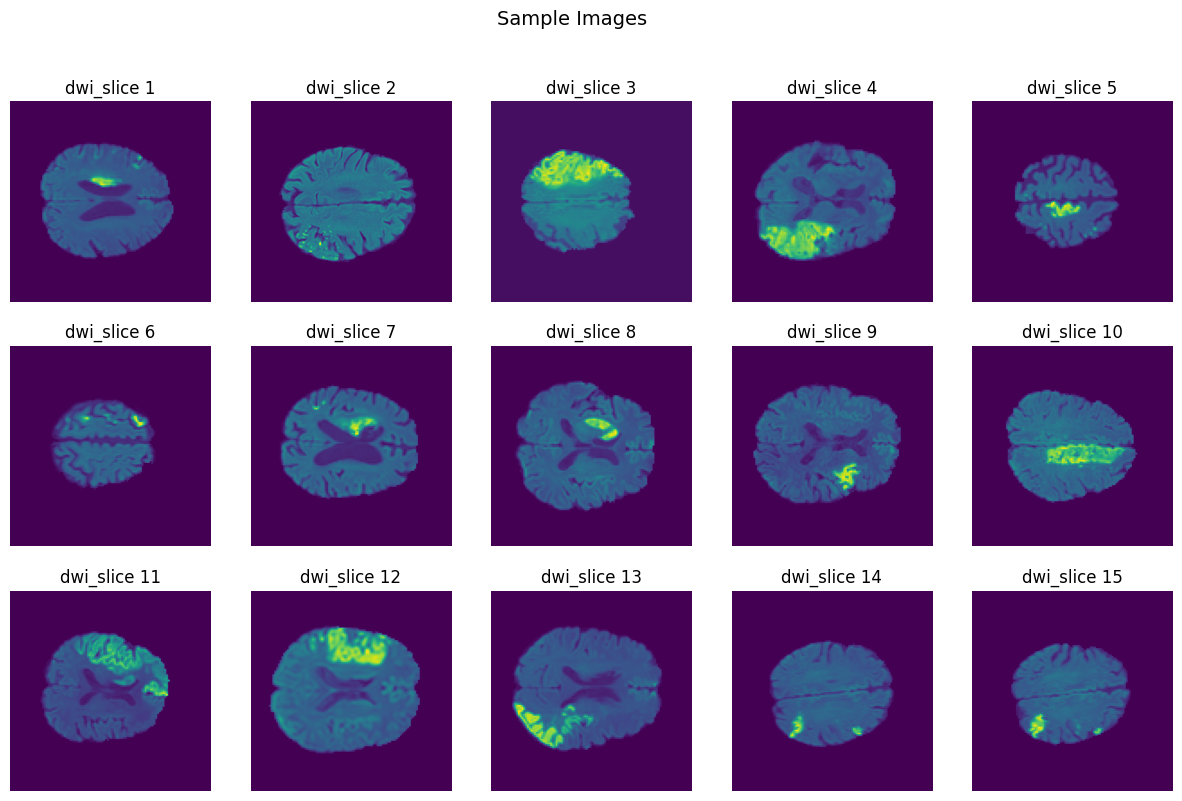

In [22]:
plt.figure(figsize=(15,9))
for i in range(len(sample_images)):
    plt.subplot(3,5,i+1)
    plt.suptitle('Sample Images', fontsize=14)
    plt.imshow(sample_images[i])
    plt.title('dwi_slice '+str(i+1))
    plt.axis('off')
plt.show()

In [ ]:
# plt.figure(figsize=(15,9))
# for i in range(len(sample_masks)):
#     plt.subplot(3,5,i+1)
#     plt.suptitle('Sample Masks', fontsize=14)
#     plt.imshow(sample_masks[i])
#     plt.title('dwi_mask '+str(i+1))
#     plt.axis('off')
# plt.show()

In [ ]:
# plt.figure(figsize=(15,9))
# for i in range(len(test_images)):
#     plt.subplot(3,5,i+1)
#     plt.suptitle('Test Images', fontsize=14)
#     plt.imshow(test_images[i])
#     plt.title('dwi_slice '+str(i+1))
#     plt.axis('off')
# plt.show()

In [ ]:
# plt.figure(figsize=(15,9))
# for i in range(len(test_masks)):
#     plt.subplot(3,5,i+1)
#     plt.suptitle('Test Masks', fontsize=14)
#     plt.imshow(test_masks[i])
#     plt.title('dwi_mask '+str(i+1))
#     plt.axis('off')
# plt.show()

In [19]:
sample_images[0].shape
print(f"Minimum intensity value: {np.min(sample_images[1])}, maximum intensity value: {np.max(sample_images[1])}")

Minimum intensity value: 0.0, maximum intensity value: 665.9959771092981


## Gaussian Mixture Model

In [20]:
def normalize_intensity(img, method='zscore'):
    """Normalize intensities to zero-mean unit-variance or min-max"""
    x = img.copy().astype(np.float32)
    if method == 'zscore':
        m = np.mean(x)
        s = np.std(x)
        if s == 0:
            return x - m
        return (x - m) / s
    elif method == 'minmax':
        mn = x.min()
        mx = x.max()
        if mx == mn:
            return x - mn
        return (x - mn) / (mx - mn)
    else:
        raise ValueError("Unknown method")

$$
f_{\mathbf{x}}(\mathbf{x}) = \frac{1}{\sqrt{(2\pi)^d |\boldsymbol{\Sigma}|}} \exp\left(-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^T \boldsymbol{\Sigma}^{-1} (\mathbf{x}-\boldsymbol{\mu})\right)
$$
$$
\text{if } \boldsymbol{\Sigma} = \sigma^2 \mathbf{I} \text{ then the distribution is spherical}
$$
$$
\text{if }  \boldsymbol{\Sigma} \text{ is diagonal but not a constant product of I then the the variables are uncorrelated, and the ellipsoid's axes are aligned with the coordinate axes.}
$$

In [28]:
def gaussian_pdf(x, mean, cov, reg_covar=1e-6):
    """
    Multivariate Gaussian probability density function.
    x: (d) sample
    mean: (d)
    cov: (d,d) covariance
    """
    d = mean.shape[0]
    cov = cov + reg_covar * np.eye(d)  # regularization for stability
    det_cov = np.linalg.det(cov)
    if det_cov <= 0:
        det_cov = reg_covar
    inv_cov = np.linalg.inv(cov)  # psuedo-inverse for stability
    diff = x - mean
    exponent = -0.5 * diff.T @ inv_cov @ diff #Exponent term of the Gaussian
    coeff = 1 / np.sqrt((2 * np.pi) ** d * det_cov) #Coefficient term of the Gaussian
    return coeff * np.exp(exponent) #Gaussian PDF value

In [ ]:
def k_means(X, K, max_iter=50, seed = 21):
    np.random.seed(seed)
    n_sample, n_feature = X.shape
    idx = np.random.choice(n_sample, K, replace=False)
    means = X[idx]
    for it in range(max_iter):
        labels = np.zeros(n_sample, dtype=int)
        for i in range(n_sample):
            dists = [np.linalg.norm(X[i] - means[k]) for k in range(K)]
            labels[i] = np.argmin(dists)
        new_means = np.zeros((K, n_feature))
        for k in range(K):
            points = X[labels == k]
            if len(points) > 0: 
                new_means[k] = points.mean(axis=0)
            else:
                new_means[k] = means[k]
        
        # Convergence check
        if np.allclose(means, new_means):
            print(f"Converged at {it+1}")
            break
        means = new_means
    return means, labels


In [32]:
X_list = []
for img in sample_images:
    X_list.append((img).reshape(-1, 1))
X = np.vstack(X_list)   # shape (sum of all pixels, 1)
X_norm = normalize_intensity(X, method='minmax') 

In [47]:
print(X_norm.shape)  # (sum of all pixels, 1)

(224000, 1)


In [96]:
means, labels = k_means(X_norm,4, max_iter=50, seed=21)

Converged at 36


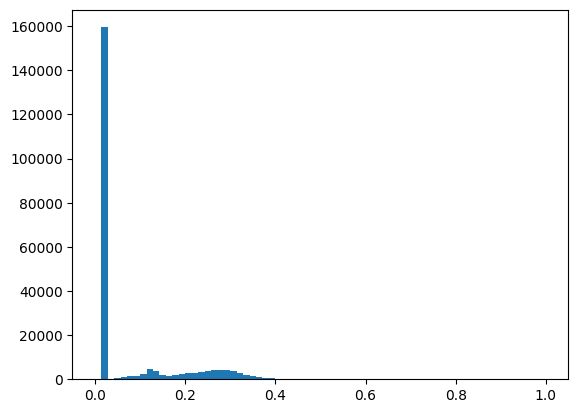

In [52]:
plt.hist(X_norm,bins=70, range=(0,1))
plt.show()

In [53]:
print(np.argmin(means))
print(means.reshape(1,-1))
print(labels.shape)  # (sum of all pixels,)

2
[[0.26741123 0.60355121 0.03235141]]
(224000,)


Converged at 25


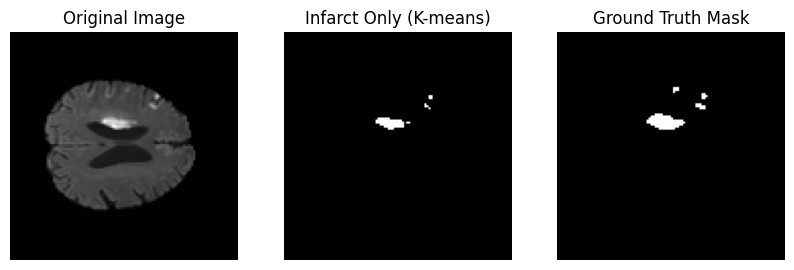

Converged at 30


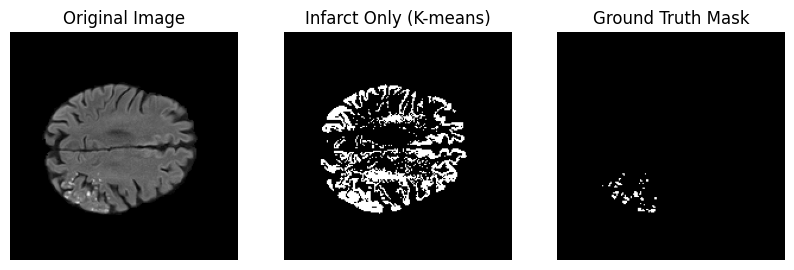

Converged at 12


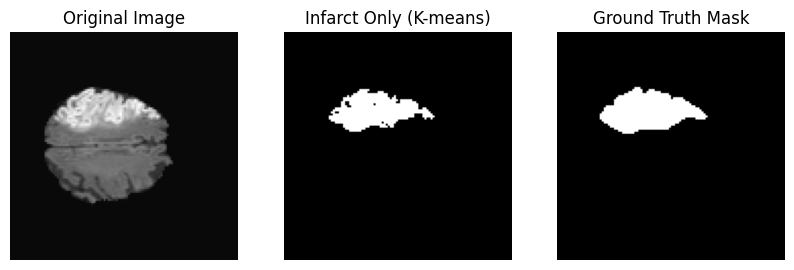

Converged at 23


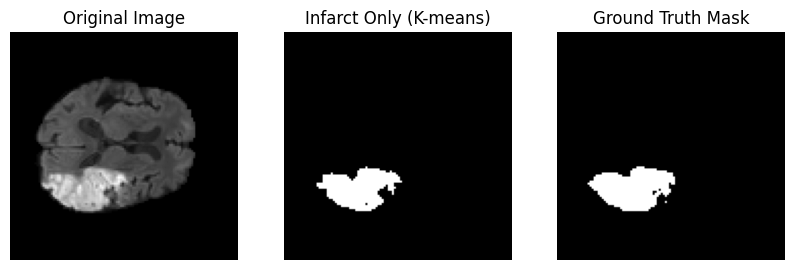

Converged at 18


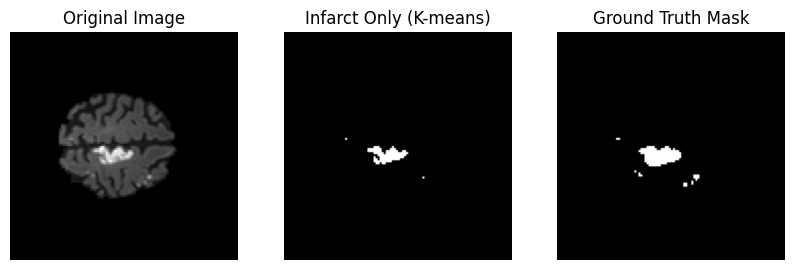

Converged at 22


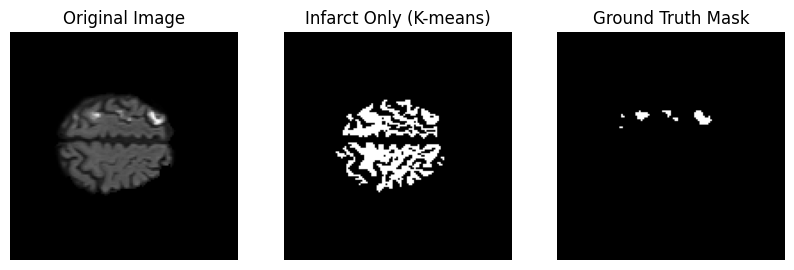

Converged at 24


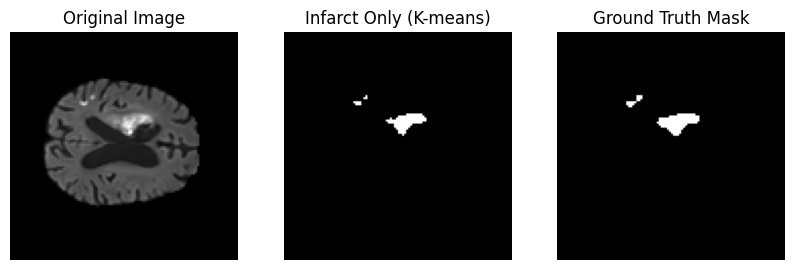

Converged at 22


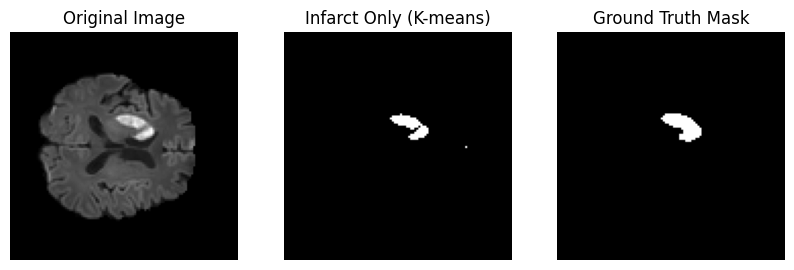

Converged at 41


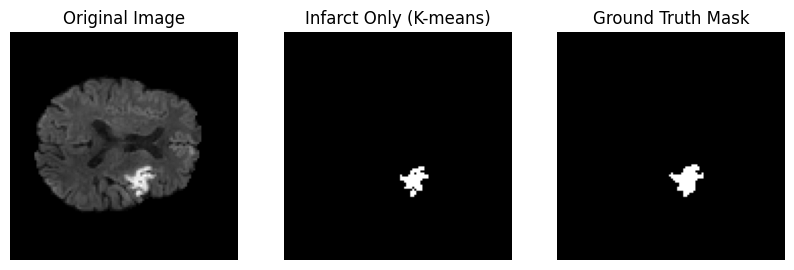

Converged at 39


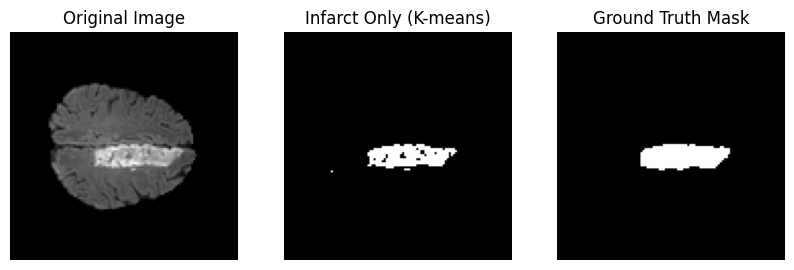

Converged at 17


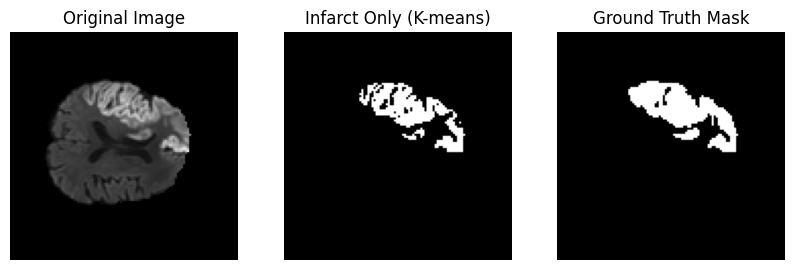

Converged at 49


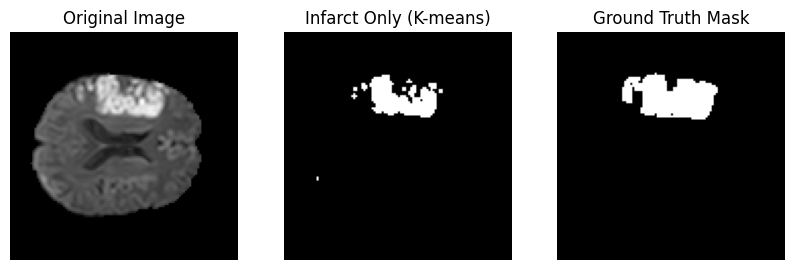

Converged at 14


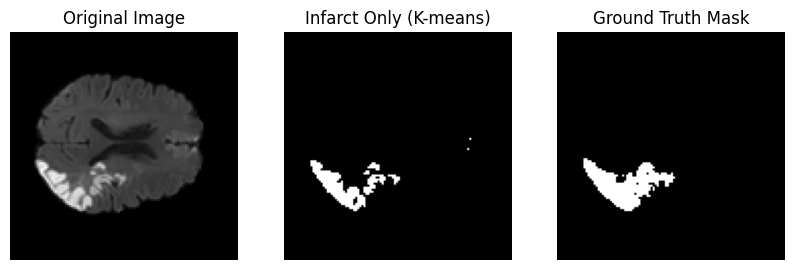

Converged at 23


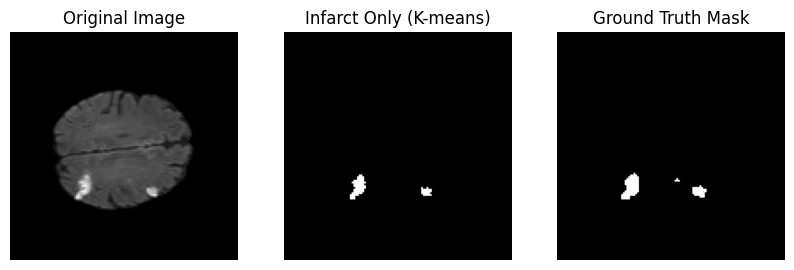

Converged at 22


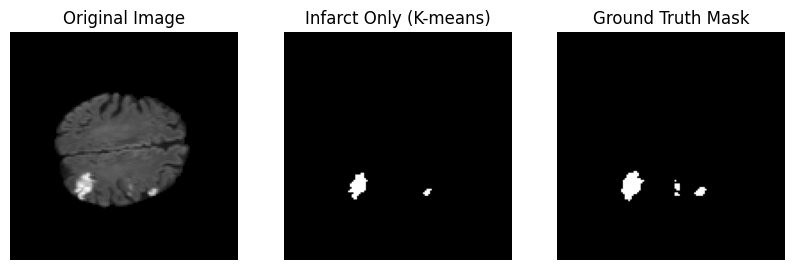

In [95]:
for idx, img in enumerate(sample_images):
    img_n = normalize_intensity(img, method='minmax')

    # Flatten image into (N,1) for clustering
    X = img_n.reshape(-1, 1)

    # Compute k-means for this image
    means, labels = k_means(X, K=4, max_iter=50, seed=21)

    # Find the cluster with the highest mean (brightest, likely infarct)
    infarct_cluster = np.argmax(means)

    # Build binary mask: infarct pixels = 1, background = 0
    binary_mask = (labels == infarct_cluster).astype(np.uint8)
    segmented_img = binary_mask.reshape(img.shape)

    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(segmented_img, cmap='gray', vmin=0, vmax=1)
    plt.title("Infarct Only (K-means)")
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(sample_masks[idx], cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")
    plt.show()

In [113]:
def GaussianMixtureModel(X, K, max_iter=100, tol=1e-4, reg_covar=1e-6, verbose=False):
    """
    Fit a Gaussian Mixture Model (GMM) using the EM algorithm.
    
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)(N,d)
        Data points.
    K : int
        Number of Gaussian components.
    max_iter : int, optional
        Maximum number of iterations for EM.
    tol : float, optional
        Convergence threshold on log-likelihood.
    reg_covar : float, optional
        Regularization term added to covariances for stability.
    verbose : bool, optional
        Print log-likelihood each iteration.
    
    Returns
    -------
    means : (K, d)
    covariances : (K, d, d)
    weights : (K,)
    responsibilities : (n_samples, K)
    log_likelihoods : list
    """
    n_samples, n_features = X.shape
    np.random.seed(21)
    means, labels = k_means(X, K, max_iter=50, seed=21)
    # Initialize parameters
    # means = X[np.random.choice(n_samples, K, replace=False)] 
    """When replace is False, it means that the same element
    cannot be selected more than once. Shape (K,d) assuming there are d features and K clusters"""
    cov = np.cov(X, rowvar=False) #When rowvar is False, each column represents a variable, while each row represents a single observation of all those variables.
    if cov.ndim == 0:  # handle 1D data
        cov = np.array([[cov]])
    covariances = np.array([cov] * K) #Initialize K covariance matrices to the same value
    weights = np.ones(K) / K #Equal initial weights. This means that initially, each Gaussian component is assumed to contribute equally to the overall mixture.
    log_likelihoods = [] #To store the log-likelihood at each iteration

    for it in range(max_iter):
        # E-step: responsibilities
        responsibilities = np.zeros((n_samples, K)) #One-hot encoded responsibilities. Each row corresponds to a probability distribution over the K components for a given data point. Shape (N,K)
        for n in range(n_samples): #Iterate over each data point
            for k in range(K): #Iterate over each Gaussian component
                responsibilities[n, k] = weights[k] * gaussian_pdf(X[n], means[k], covariances[k], reg_covar) #Calculate the responsibility of component k for data point n
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)  # When axis=1, it means we are summing across the columns for each row. keepdims=True ensures that the result 
        #maintains the same number of dimensions as the input array, which is important for broadcasting during division.

        # M-step: update parameters
        Nk = responsibilities.sum(axis=0)  # effective number of points per cluster. Summing each column to get the total responsibility assigned to each cluster across all data points. Shape (K,)[N1,N2,...,Nk]
        for k in range(K):
            # Update means
            means[k] = (responsibilities[:, k][:, np.newaxis] * X).sum(axis=0) / Nk[k] #New mean is the weighted average of all data points, weighted by their responsibilities to cluster k. 
            #np.newaxis is used to convert the 1D array responsibilities[:, k] of shape (N,) into a 2D column vector of shape (N, 1). This allows for proper broadcasting when multiplying with X, which has shape (N, d).
            # Update covariances
            diff = X - means[k]
            covariances[k] = (responsibilities[:, k][:, np.newaxis] * diff).T @ diff / Nk[k] #Weighted covariance calculation
            #Here, responsibilities[:, k][:, np.newaxis] creates a column vector of shape (N, 1) from the responsibilities for cluster k. This allows for element-wise multiplication with diff, which has shape (N, d).
            # The result is a weighted version of diff, where each row (data point) is scaled by its responsibility to cluster k. 
            
            # Update weights
            weights[k] = Nk[k] / n_samples

        # Compute log-likelihood
        log_likelihood = 0
        for n in range(n_samples):
            prob = 0
            for k in range(K):
                prob += weights[k] * gaussian_pdf(X[n], means[k], covariances[k], reg_covar) #Total probability of data point n under the mixture model. p(x) = sum of p(x|zk =1)p(zk=1) over all k
            log_likelihood += np.log(prob + 1e-12) #Adding a small constant to avoid log(0)
        log_likelihoods.append(log_likelihood)

        if verbose:
            print(f"Iteration {it+1}, log-likelihood = {log_likelihood:.6f}")

        # Convergence check
        if it > 0 and abs(log_likelihood - log_likelihoods[-2]) < tol: #If the change in log-likelihood between iterations is less than tolerance, we consider the algorithm to have converged.
            if verbose:
                print("Converged.")
            break

    return means, covariances, weights, responsibilities, log_likelihoods


In [114]:
# means, covariances, weights, responsibilities, log_likelihoods = GaussianMixtureModel(X_norm, K=4, max_iter=100, tol=1e-4, verbose=True)

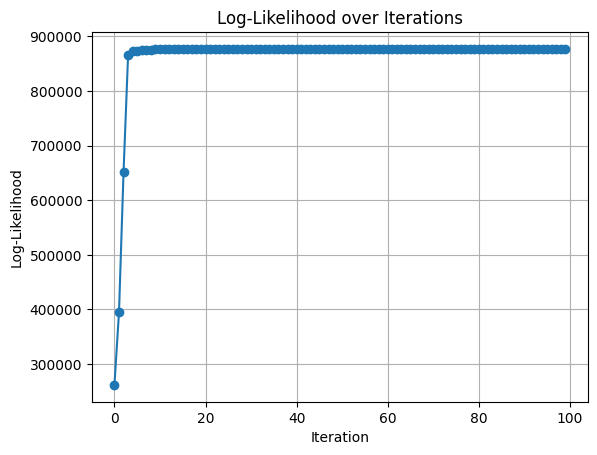

In [99]:
plt.plot(log_likelihoods, marker='o')
plt.title("Log-Likelihood over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.grid()
plt.show()

In [115]:
# print(f"Shape of Means are {means}", sep=" ")
# print(f"Shape of Covariances are {covariances}")
# print(f"weights {weights}")
# print(f"Responsibilities {responsibilities.shape}")  # (N, K)

In [118]:
def select_infarct_cluster(means, segmented, image, min_frac=0.005, max_frac=0.5):
    """
    Pick the cluster corresponding to infarct:
      - infarcts on DWI are typically hyperintense (brightest cluster)
      - apply size constraints to avoid background/artifacts
    Inputs:
      - means: (K, 1) array of cluster means
      - segmented: (H, W) array of cluster labels from GMM
      - image: (H, W) original image intensities
      - min_frac, max_frac: allowable fraction of total pixels for infarct cluster
    Returns:
      index of chosen cluster
    """
    H, W = image.shape
    Npix = H * W
    K = means.shape[0]

    cluster_mean_intensity = []
    cluster_sizes = []

    for k in range(K):
        mask = (segmented == k)
        cluster_sizes.append(mask.sum())
        if mask.sum() == 0:
            cluster_mean_intensity.append(-np.inf)
        else:
            cluster_mean_intensity.append(np.mean(image[mask]))

    order = np.argsort(np.array(cluster_mean_intensity).ravel())[::-1]

    for idx in order:
        frac = cluster_sizes[idx] / Npix
        if min_frac <= frac <= max_frac:
            return idx

    # fallback: pick the brightest
    return order[0]


In [120]:
def postprocess_mask(binary_mask, min_area=100, closing_radius=2):
    """
    Morphological cleanup:
     - remove small objects
     - closing to fill holes
     - keep largest connected component
    Inputs:
      - binary_mask: (H, W) boolean or 0/1 mask
    Returns:
      final cleaned binary mask (uint8: 0/1)
    """
    # remove small specks
    cleaned = morphology.remove_small_objects(binary_mask.astype(bool), min_size=min_area)

    # closing with disk structuring element
    selem = morphology.disk(closing_radius)
    closed = morphology.binary_closing(cleaned, selem)

    # label connected components
    labels = measure.label(closed)
    if labels.max() == 0:
        return closed.astype(np.uint8)

    props = measure.regionprops(labels)
    largest_label = max(props, key=lambda p: p.area).label
    final = (labels == largest_label)
    return final.astype(np.uint8)


Converged at 25
Converged at 30
Converged at 12
Converged at 23
Converged at 18
Converged at 22
Converged at 24
Converged at 22
Converged at 41
Converged at 39
Converged at 17
Converged at 49
Converged at 14
Converged at 23
Converged at 22


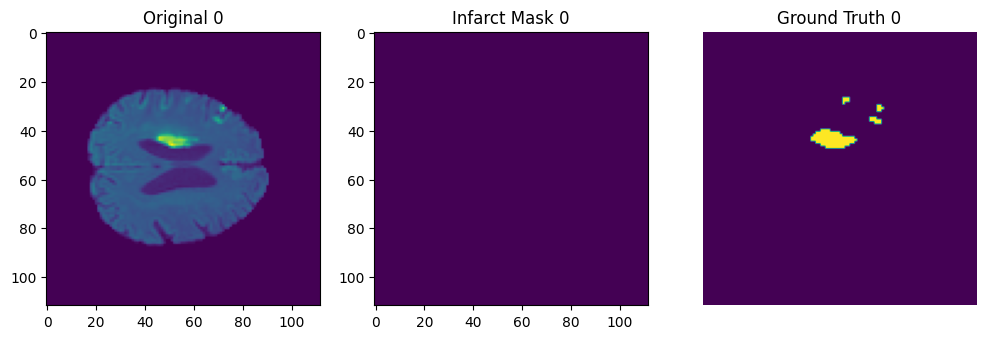

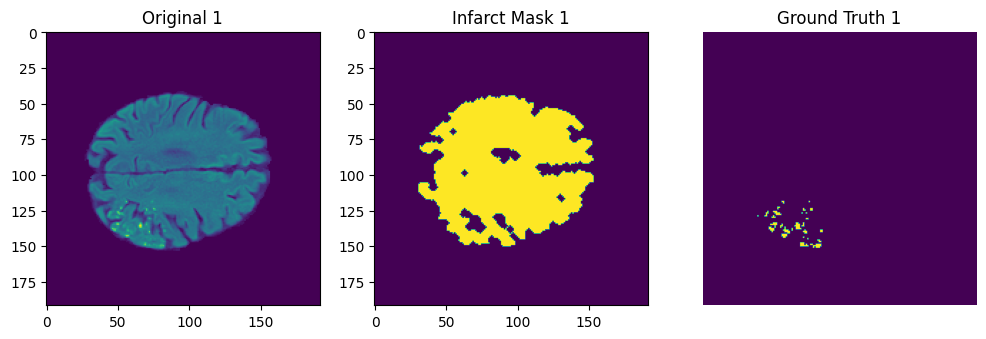

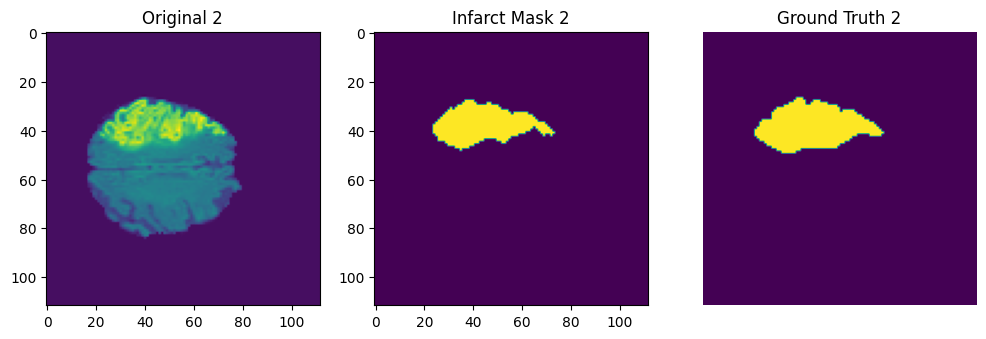

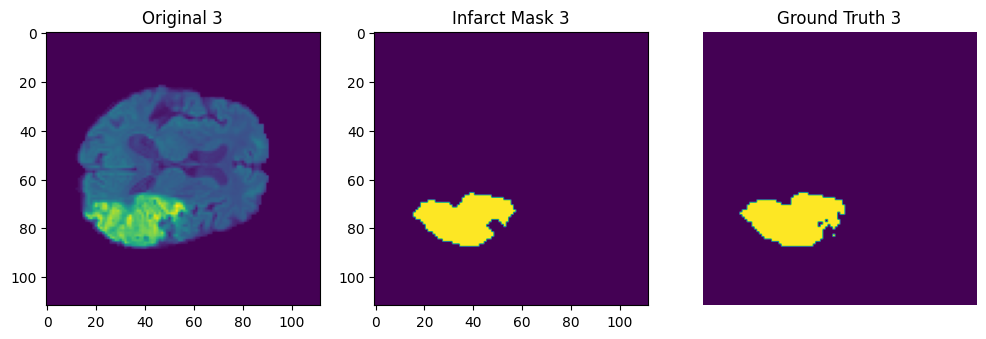

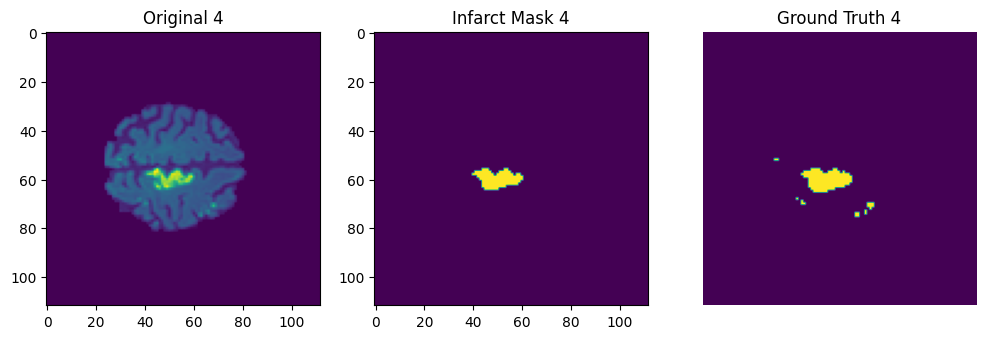

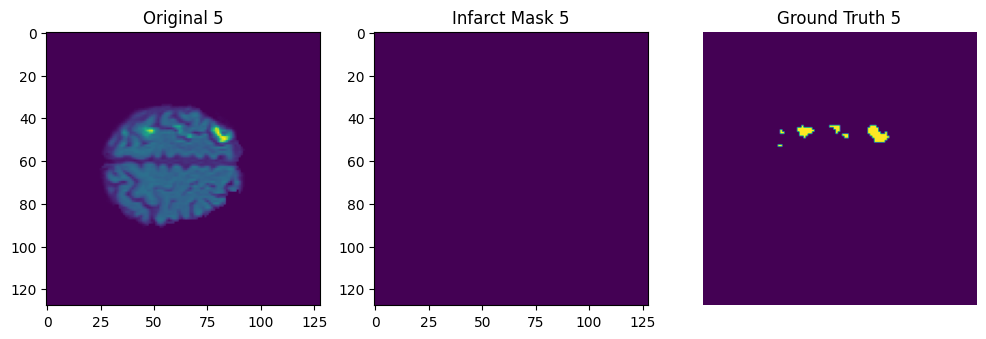

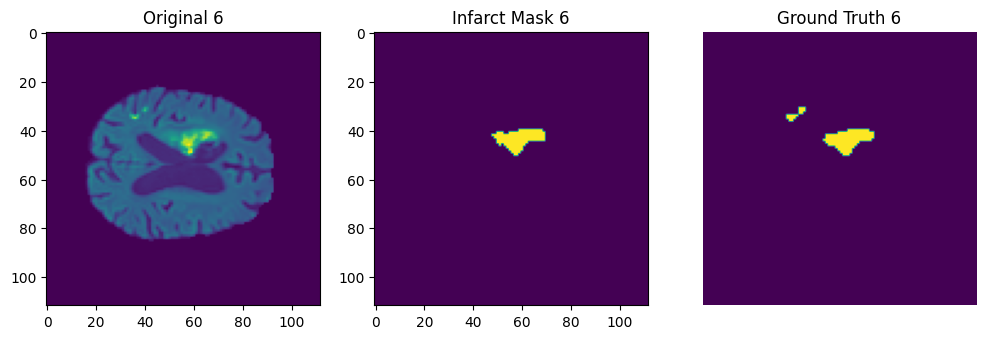

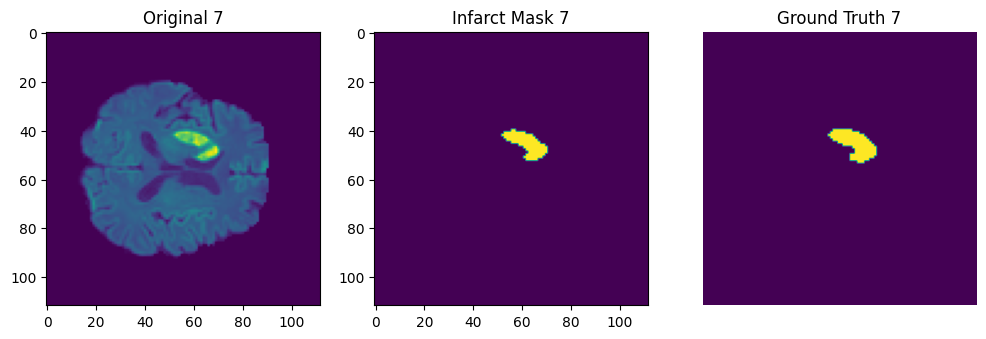

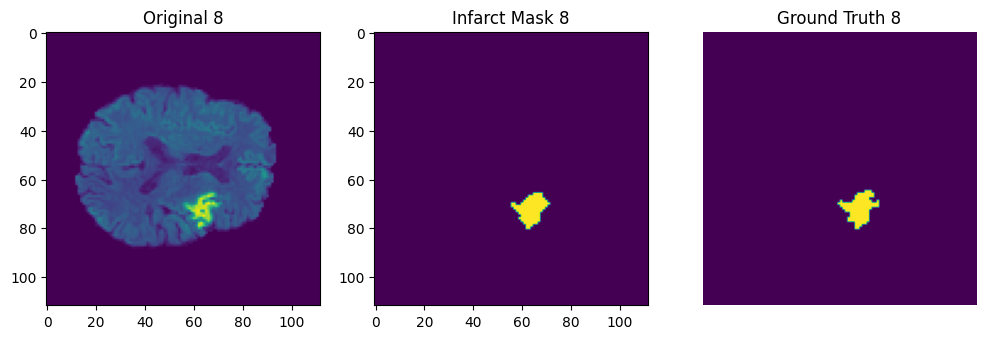

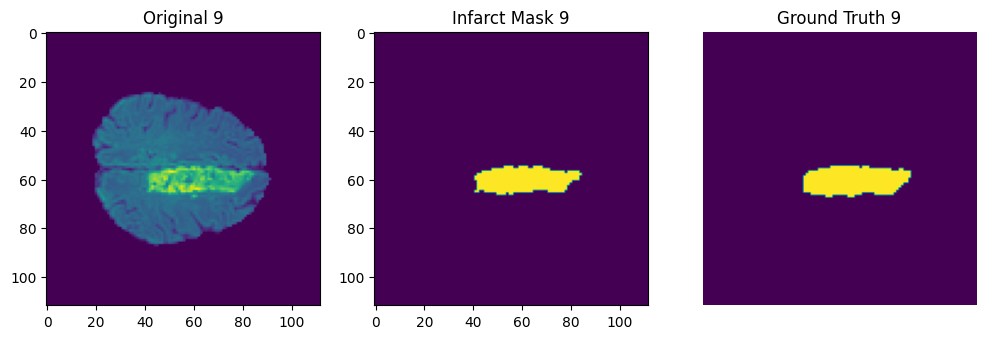

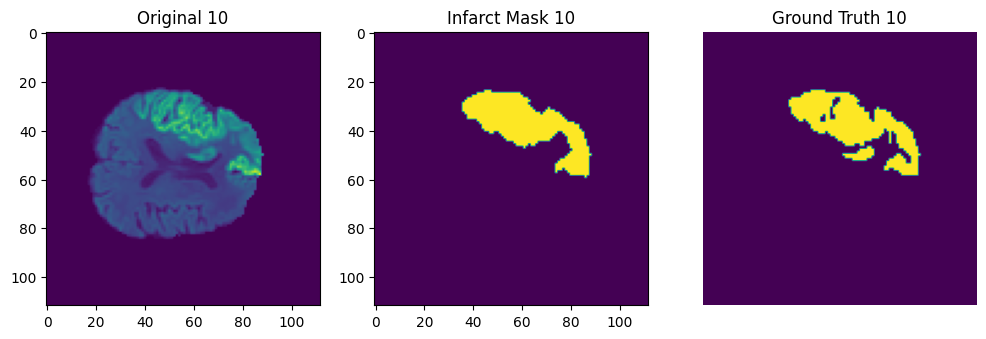

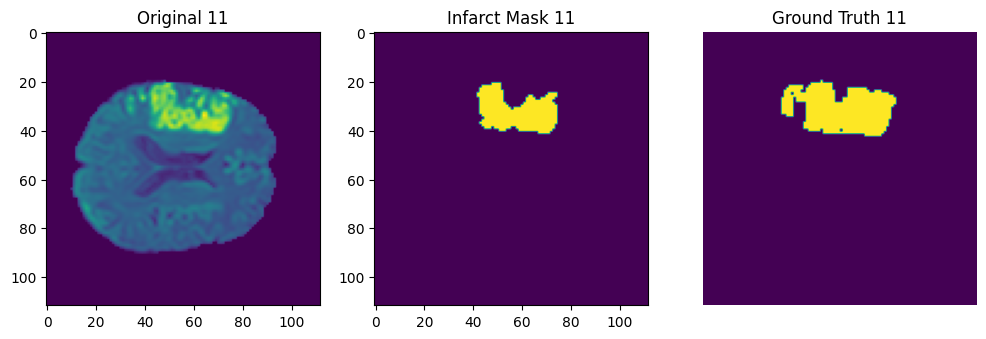

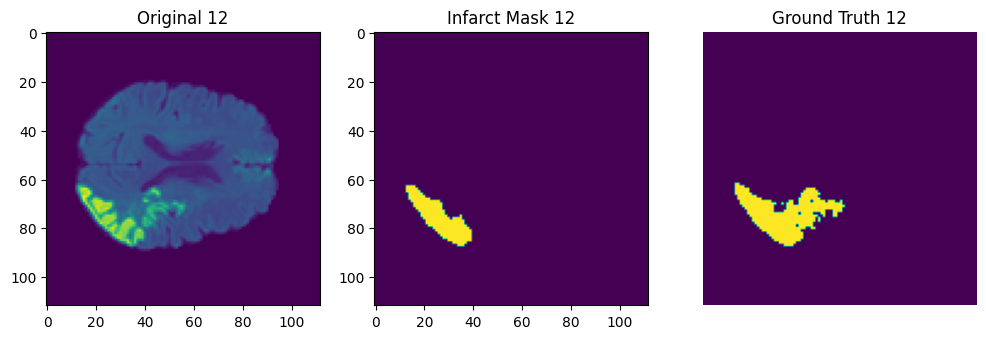

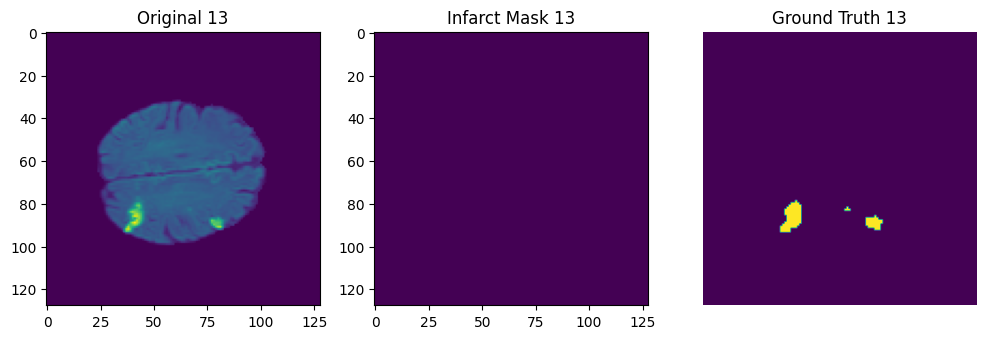

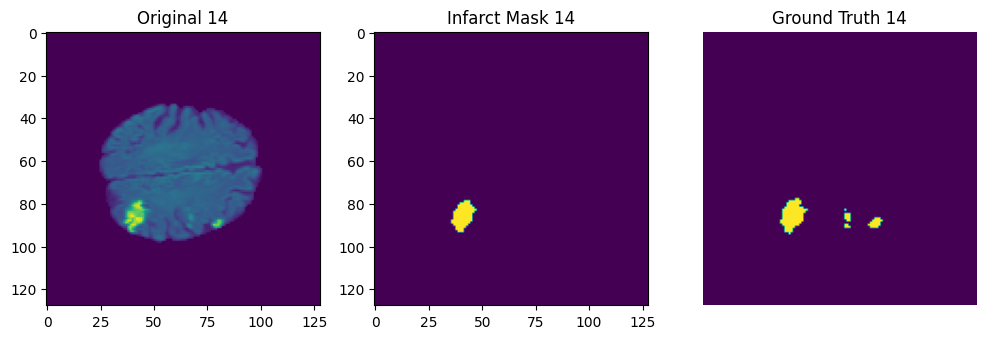

In [121]:
for i in range(len(sample_images)):
    img = sample_images[i]
    normalized_img = normalize_intensity(img)
    X = normalized_img.reshape(-1, 1)
    means, covariances, weights, responsibilities, _ = GaussianMixtureModel(X, K=4, max_iter=50, tol=1e-4)
    labels = np.argmax(responsibilities, axis=1)
    segmented = labels.reshape(img.shape)
    infarct_idx = select_infarct_cluster(means, segmented, normalized_img)

    # Build binary mask
    binary_mask = (segmented == infarct_idx)

    # Clean it up
    final_mask = postprocess_mask(binary_mask)

    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title(f"Original {i}")
    plt.subplot(1,3,2)
    plt.imshow(final_mask)
    plt.title("Infarct Mask " +str(i))
    plt.subplot(1,3,3)
    plt.imshow(sample_masks[i])
    plt.title("Ground Truth " +str(i))
    plt.axis("off")
plt.show()


In [122]:
def dice_coefficient(gt, pred, eps=1e-8):
    gt = gt.astype(bool)
    pred = pred.astype(bool)
    inter = np.logical_and(gt, pred).sum()
    return 2.0 * inter / (gt.sum() + pred.sum() + eps)

In [123]:
def lesion_wise_f1_and_counts(gt, pred, iou_threshold=0.1):
    """
    Lesion-wise F1:
      - find connected components in GT and pred
      - declare a GT lesion matched if any predicted lesion has IoU > threshold
      - declare a predicted lesion matched if it matches a GT
      - compute precision, recall -> F1
    Returns: f1, GT_count, pred_count
    """
    gt_labels = measure.label(gt.astype(bool))
    pred_labels = measure.label(pred.astype(bool))
    gt_props = measure.regionprops(gt_labels)
    pred_props = measure.regionprops(pred_labels)

    GT_n = len(gt_props)
    P_n = len(pred_props)
    matched_gt = 0
    matched_pred = 0

    # build bounding boxes and pixel sets for efficiency
    pred_masks = []
    for p in pred_props:
        pred_masks.append((p.label, pred_labels == p.label))

    for g in gt_props:
        gmask = (gt_labels == g.label)
        matched = False
        for plabel, pmask in pred_masks:
            inter = np.logical_and(gmask, pmask).sum()
            union = np.logical_or(gmask, pmask).sum()
            iou = inter / union if union > 0 else 0.0
            if iou >= iou_threshold:
                matched = True
                break
        if matched:
            matched_gt += 1

    # predicted matched count
    gt_masks = []
    for g in gt_props:
        gt_masks.append((g.label, gt_labels == g.label))
    for p in pred_props:
        pmask = (pred_labels == p.label)
        matched = False
        for glabel, gmask in gt_masks:
            inter = np.logical_and(gmask, pmask).sum()
            union = np.logical_or(gmask, pmask).sum()
            iou = inter / union if union > 0 else 0.0
            if iou >= iou_threshold:
                matched = True
                break
        if matched:
            matched_pred += 1

    precision = matched_pred / (P_n + 1e-8)
    recall = matched_gt / (GT_n + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8) if (precision+recall)>0 else 0.0
    return f1, GT_n, P_n

In [124]:
def segment_slice_with_gmm(slice_img, K=3, smoothing_sigma=0.1, intensity_norm='minmax',
                           min_frac=0.0005, max_frac=0.5, em_max_iter=200, em_tol=1e-5,
                           reg_covar=1e-6, verbose=False):
    """
    Input:
      slice_img: 2D numpy array (H,W) intensity
    Returns:
      final_mask (binary HxW), cluster_masks(list of HxW), means, covariances, responsibilities
    """
    H, W = slice_img.shape
    img_s = gaussian_filter(slice_img, sigma=smoothing_sigma)
    img_n = normalize_intensity(img_s, method=intensity_norm)
    # Flatten pixels as samples (n=Dpix, d=1)
    X = img_n.reshape(-1, 1)  # (n_pixels, 1)

    # Fit GMM
    means, covs, weights, resp, lls = GaussianMixtureModel(X, K, max_iter=em_max_iter, tol=em_tol, reg_covar=reg_covar, verbose=verbose)

        # build cluster masks
    labels = np.argmax(resp, axis=1)  # per-pixel cluster assignment
    cluster_masks = []
    for k in range(K):
        mask = (labels == k).reshape(H, W)
        cluster_masks.append(mask)

    # select infarct cluster using rule
    chosen_idx = select_infarct_cluster(means, labels.reshape(H, W), img_n, min_frac=min_frac, max_frac=max_frac)
    chosen_mask = cluster_masks[chosen_idx].astype(np.uint8)

    # Postprocess
    final_mask = postprocess_mask(chosen_mask, min_area=50, closing_radius=3)

    return final_mask, cluster_masks, means, covs, weights, resp, lls

In [125]:
# DICE and lesion-wise F1 evaluation on sample images
dice_scores = []
f1_scores = []
for i in range(len(sample_images)):
    img = sample_images[i]
    gt_mask = sample_masks[i]
    pred_mask, _, _, _, _, _, _ = segment_slice_with_gmm(img, K=4, smoothing_sigma=0.5, intensity_norm='minmax',
                                                         min_frac=0.0005, max_frac=0.5, em_max_iter=100, em_tol=1e-4,
                                                         reg_covar=1e-6, verbose=False)
    dice = dice_coefficient(gt_mask, pred_mask)
    f1, GT_n, P_n = lesion_wise_f1_and_counts(gt_mask, pred_mask, iou_threshold=0.1)
    dice_scores.append(dice)
    f1_scores.append(f1)
    print(f"Sample Image {i+1}: Dice={dice:.4f}, Lesion-wise F1={f1:.4f}, GT lesions={GT_n}, Pred lesions={P_n}")
print(f"Average Dice on Sample Images: {np.mean(dice_scores):.4f}")
print(f"Average Lesion-wise F1 on Sample Images: {np.mean(f1_scores):.4f}")


Converged at 32
Sample Image 1: Dice=0.8152, Lesion-wise F1=0.4000, GT lesions=4, Pred lesions=1
Sample Image 2: Dice=0.0145, Lesion-wise F1=0.0000, GT lesions=25, Pred lesions=1
Converged at 15
Sample Image 3: Dice=0.9044, Lesion-wise F1=1.0000, GT lesions=1, Pred lesions=1
Converged at 20
Sample Image 4: Dice=0.9447, Lesion-wise F1=0.6667, GT lesions=2, Pred lesions=1
Converged at 20
Sample Image 5: Dice=0.8690, Lesion-wise F1=0.2500, GT lesions=7, Pred lesions=1
Converged at 40
Sample Image 6: Dice=0.0000, Lesion-wise F1=0.0000, GT lesions=6, Pred lesions=0
Converged at 28
Sample Image 7: Dice=0.8609, Lesion-wise F1=0.6667, GT lesions=2, Pred lesions=1
Converged at 25
Sample Image 8: Dice=0.9310, Lesion-wise F1=1.0000, GT lesions=1, Pred lesions=1
Converged at 44
Sample Image 9: Dice=0.9158, Lesion-wise F1=1.0000, GT lesions=1, Pred lesions=1
Converged at 49
Sample Image 10: Dice=0.9494, Lesion-wise F1=1.0000, GT lesions=1, Pred lesions=1
Converged at 28
Sample Image 11: Dice=0.9257